In [8]:
import pickle

data = pickle.load(open('./data/data.pkl', 'rb'))

X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train = X_train[:, :, :2]
X_test = X_test[:, :, :2]

import torch

# 将NumPy数组转化为PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)  # 确保类别为int, 所以转换为long

# 对测试集也执行同样的步骤
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.long)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(138855, 7, 6) (138855,) (41008, 7, 6) (41008,)
torch.Size([138855, 7, 2]) torch.Size([138855])
torch.Size([41008, 7, 2]) torch.Size([41008])


In [9]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden_size):
        super(LSTMModel, self).__init__()  # 基类初始化
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)  # 输出层，二分类问题

    def forward(self, x):
        # 前向传播
        lstm_out, (h, c) = self.lstm(x)  # lstm_out的形状是(batch_size, seq_len, hidden_size)
        out = self.dropout(lstm_out)
        out = self.fc(out[:, -1, :])  # 取序列最后时间点的信息作为输出
        return out.squeeze()

# 初始模型
n_features = X_train.shape[2]  # 每个时间点有多少特征
lstm_model = LSTMModel(n_features, hidden_size=16)

In [ ]:
# 设置训练参数
learning_rate = 1e-2
# 使用Adam作为优化器
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
# 使用二分类交叉熵作为损失函数
criterion = nn.BCEWithLogitsLoss()

# 训练模型
def train(lstm_model, epochs=20, batch_size=64):
    # 设置模型为训练模式
    lstm_model.train()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    lstm_model.to(device)  # 将模型移至GPU

    # 训练阶段
    for epoch in range(epochs):
        avg_loss = 0.
        for i in range(0, len(X_train), batch_size):
            # forward
            X_batch, y_batch = X_train[i:i+batch_size].to(device), y_train[i:i+batch_size].to(device)
            y_pred = lstm_model(X_batch)
            loss = criterion(y_pred, y_batch.float())  # 输出为概率，所以需要浮点

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_loss += loss.item() / len(X_train)
        print('Epoch: {}, Loss average: {:.4f}'.format((epoch+1), avg_loss))
    return lstm_model

# 训练模型
trained_model = train(lstm_model)

Epoch: 1, Loss average: 0.0103
Epoch: 2, Loss average: 0.0103
Epoch: 3, Loss average: 0.0103
Epoch: 4, Loss average: 0.0103
Epoch: 5, Loss average: 0.0103
Epoch: 6, Loss average: 0.0103
Epoch: 7, Loss average: 0.0103
Epoch: 8, Loss average: 0.0103
Epoch: 9, Loss average: 0.0102
Epoch: 10, Loss average: 0.0103


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 使用训练好的模型进行预测
lstm_model.eval()  # 将模型切换为评估模式
test_pred = lstm_model(X_test.to(device)).detach().cpu().numpy()  # 需要使用detach以移除计算图
predicted_labels = (test_pred > 0.5).astype(int)  # 预测结果大于0.5的划分到一类

# 模型性能评估
from sklearn.metrics import accuracy_score, confusion_matrix
print("Accuracy:", accuracy_score(y_test, predicted_labels))
print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_labels))

Accuracy: 0.4916357783847054
Confusion Matrix:
 [[20161     0]
 [20847     0]]


Accuracy: 0.4916357783847054
Confusion Matrix:
 [[20161     0]
 [20847     0]]


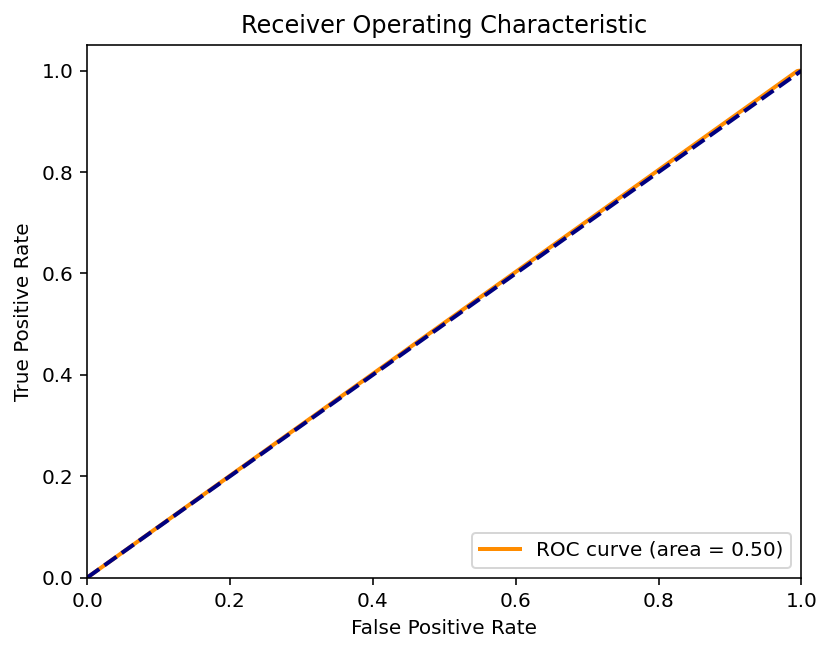

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

print("Accuracy:", accuracy_score(y_test, predicted_labels))
print("Confusion Matrix:\n", confusion_matrix(y_test, predicted_labels))

# 计算ROC曲线
fpr, tpr, _ = roc_curve(y_test, test_pred)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(dpi=144)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()